In [1]:
# !pip install geopy
# !pip install -U googlemaps
# !pip install folium

In [2]:
import sys
import os
import re
import pandas as pd
import numpy as np

import eli5
import geopy
import folium
import googlemaps
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_root = 'datasets'
data_filename = 'reto_precios.csv'

data_path = os.path.join(data_root, data_filename)
f'Data located at: {data_path}'

'Data located at: datasets/reto_precios.csv'

In [5]:
df = pd.read_csv(data_path)
df.drop('id', axis=1, inplace=True)
df.head(3)

,main_name,subtitle,link,location,price,attributes,timestamp,address,since,description,...,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,Garden house con 2 habitaciones y dos baños c...,...,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,Tonala,Publicado hace 7 días,Mezcla perfecta entre E S T I L O y C A L I D ...,...,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,"Concepto único en Roma Sur, es un desarrollo d...",...,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233


In [6]:
# Check de NaNs
df.isna().sum(axis=0)

main_name                 0
subtitle                  0
link                      0
location                  0
price                     0
attributes                0
timestamp                 0
address                 279
since                     0
description               0
vendor                    0
lat                       0
lon                       0
price_mod                 0
price_currency            0
since_period              0
since_value               0
days_on_site              0
amenities               477
age_in_years              0
bathrooms                 0
cellars                 929
num_floors              897
monthly_fee             853
apartments_per_floor    966
disposition             961
parking_lots              0
floor_situated          957
orientation             973
num_bedrooms              0
department_type         942
m2                        0
final_price               0
price_square_meter        0
dtype: int64

In [7]:
f'Total num of registries: {df.shape[0]}'

'Total num of registries: 981'

In [8]:
# Extración del lugar de la vivienda
df['city'] = df[['location']].applymap(lambda x: x.split(',')[-1].strip()) 
df['city'].value_counts()

Distrito Federal    944
Nuevo León           36
Baja California       1
Name: city, dtype: int64

De acuerdo a la distribución de las localidades de los departamentos y casas es evidente que existe un problema de desbalance entre las ciudad. Baja California solo reporta una propiedad y será dificil aprender el precio por metro cuadrado para esta localidad especifica.

## Funciones de Ayuda

In [9]:
def plot_map_per_location(df, location: str):
    m = folium.Map(scrollWheelZoom=False)

    df_city = df[df.city == location]
    print(f'Numero de propiedades: {df_city.shape[0]}\n')

    for lat, lon in df_city[['lat', 'lon']].values:
        folium.Marker([lat, lon]).add_to(m)

    sw = df_city[['lat', 'lon']].min().values.tolist()
    ne = df_city[['lat', 'lon']].max().values.tolist()

    m.fit_bounds([sw, ne]) 
    return m

# Plot Propiedades

In [10]:
plot_map_per_location(df, 'Distrito Federal')

Numero de propiedades: 944



In [11]:
plot_map_per_location(df, 'Nuevo León')

Numero de propiedades: 36



In [12]:
plot_map_per_location(df, 'Baja California')

Numero de propiedades: 1



Se puede observar claramente que existe un problema de balanceo en las propiedades analizadas. La mayoría se encuentra ubicada prácticamente en la misma región de Ciudad de México. Luego de realizar alguna validación por internet para averiguar el precio promedio en la ubicación zip code del CDMX se pudo evidenciar que los precios son muy similares, por ende es muy probable que con las características o features sea muy complicado estimar el precio por metro cuadrado de las propiedades.

## Extracción Zip Code y otra informacion
En la siguiente sección se utilizará OpenStreetMap para extraer información adicional por cada propiedad dada su latitud y longitud. 

In [13]:
def get_distrinct(full_address, left_txt, right_txt):
    try:
        return re.search('%s(.*)%s' % (left_txt, right_txt), full_address).group(1).strip()
    except:
        return None

In [14]:
def get_extra_info_from_location(lat, lon):
    '''
    Func that uses OpenStreetMap that helps to 
    extract amenities, neighbourhood and postcode
    '''
    
    geolocator = geopy.Nominatim(user_agent='assessment-camilo')
    reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
    location = reverse((lat, lon))
    
    address = location.raw['address']
    neighbourhood = address.get('neighbourhood')
    city = address.get('city')
    amenity = address.get('amenity')
    postcode = address.get('postcode')
    
    if neighbourhood is None or city is None:
        district = None
    else:   
        district = get_distrinct(
            full_address=location.raw['display_name'],
            left_txt=neighbourhood + ',',
            right_txt=', ' + city
        )
    
    return amenity, \
           neighbourhood, \
           postcode, \
           district

In [15]:
try:
    extra_info_df = pd.read_csv(os.path.join(data_root, 'extra_info.csv'))
except:
    print('Calling OpenStreedMap!')
    extra_info = [
        get_extra_info_from_location(lat, lon)
        for lat, lon in df[['lat', 'lon']].values
    ]

    extra_info_df = pd.DataFrame(
        extra_info, 
        columns=['amenity', 'neighbourhood', 'postcode', 'district']
    )

extra_info_df.head()

,amenity,neighbourhood,postcode,district
0,Café Curado - Specialty Coffee,Colonia Roma Norte,6700.0,Cuauhtémoc
1,Banco Azteca,Colonia Roma Norte,6700.0,Cuauhtémoc
2,NaN,Colonia Roma Sur,6760.0,Cuauhtémoc
3,NaN,Colonia Roma Sur,6760.0,Cuauhtémoc
4,NaN,Colonia Juárez,6700.0,Cuauhtémoc


In [16]:
f'Total número de propiedades: {df.shape[0]}'

'Total número de propiedades: 981'

A continuación se detallan todos los distritos extraidos con OpenStretMap para todas las propiedades. La mayoría se ubica en Cuauhtémoc mostrando un problema de desbalance de los datos.

In [17]:
extra_info_df.district.value_counts()

Cuauhtémoc        923
Benito Juárez      11
Miguel Hidalgo      5
Álvaro Obregón      1
Name: district, dtype: int64

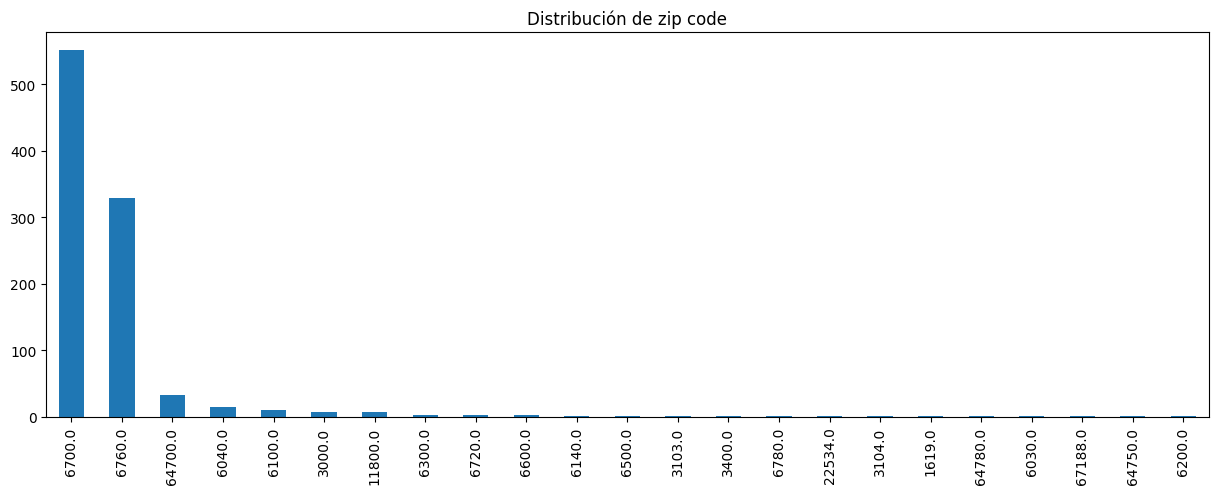

In [18]:
extra_info_df.postcode.value_counts().plot(kind='bar', figsize=(15, 5), title='Distribución de zip code');

Una vez validado la nueva, se procede a un chequeo de NaNs y la concatenación con la nueva data generada

In [19]:
extra_info_df.isna().sum(axis=0)

amenity          740
neighbourhood      5
postcode           3
district          41
dtype: int64

In [20]:
full_df = pd.concat([df, extra_info_df], axis=1)
full_df.head(2)

,main_name,subtitle,link,location,price,attributes,timestamp,address,since,description,...,num_bedrooms,department_type,m2,final_price,price_square_meter,city,amenity,neighbourhood,postcode,district
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,Garden house con 2 habitaciones y dos baños c...,...,2.0,NaN,127.0,9000000.0,70866.141732,Distrito Federal,Café Curado - Specialty Coffee,Colonia Roma Norte,6700.0,Cuauhtémoc
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,Tonala,Publicado hace 7 días,Mezcla perfecta entre E S T I L O y C A L I D ...,...,1.0,NaN,54.0,4264000.0,78962.962963,Distrito Federal,Banco Azteca,Colonia Roma Norte,6700.0,Cuauhtémoc


Se valida adicionalmente la fecha de las propiedad publicadas.

In [21]:
full_df.timestamp.value_counts()

2022-03-29    981
Name: timestamp, dtype: int64

## Analisis de Precio Final
A pesar de que se quiere estimar el metro cuadrado de cada propiedad es preferible analizar el precio total del inmueble ya que el precio por m2, al ser una medida de radio, puede ser confusa. Es decir, una propiedad con precio y m2 diferentes pueden tener el mismo valor.

$ propiedad1 = precio / m2 = 1000 / 2 = 500$ <br>
$ propiedad2 = precio / m2 = 500 / 1 = 500$

Como se muestra en el ejemplo anterior, ambas propiedad tiene un valor de 500 USD / m2 pero su precio y metros cuadrados son diferentes. Por tal razón es mejor estimar el precio final y dividirlo para el metraje adecuador y así obtener el valor deseado.

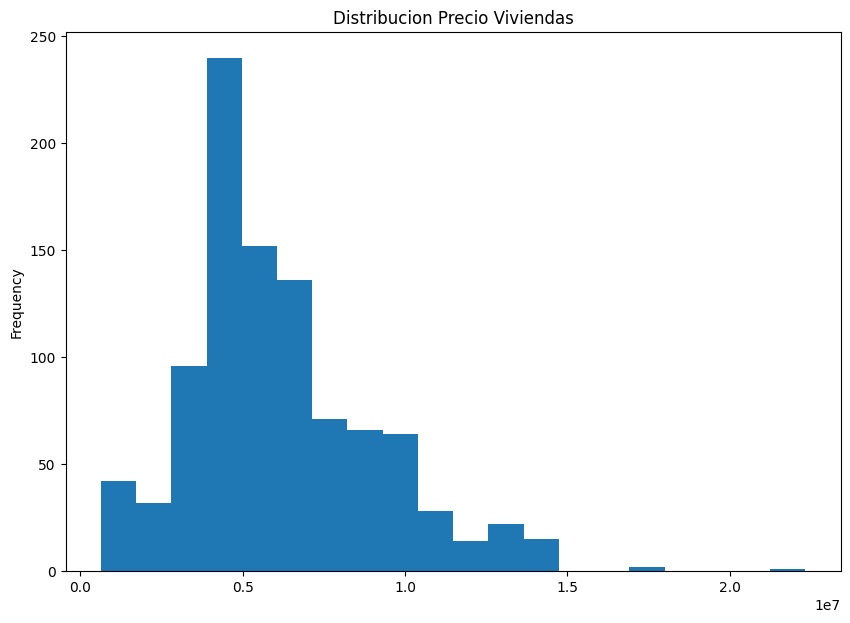

In [22]:
full_df.final_price.plot.hist(bins=20, 
                              figsize=(10, 7),
                              title='Distribucion Precio Viviendas');

Para conocer las variables que más impactan en la estimación del precio por metro cuadrado se procede a cambiar el problema por uno de clasificación. Con tal fin, se procede a binnearizar la variable objetivo que es el precio final. Se indicó anteriormente que es preferible estimar el precio en vez del precio por metro cuadrado.

In [23]:
min_ = full_df.final_price.min()
max_ = full_df.final_price.max()

bin_size = 9

bins = np.linspace(min_, max_, num=bin_size, endpoint=True)
labels = np.arange(1, len(bins))

Sin duda existen actualmente mejores opciones para binearizar alguna variable, inclusive métodos con optimización pero aquí se decidió utilizar el método convencional.

In [24]:
full_df['final_price_bin'] = pd.cut(
    x=full_df['final_price'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,
)

## Análisis Descriptivo 

In [25]:
full_df.final_price_bin.value_counts()

2    440
3    246
1    122
4    119
5     44
6      7
7      2
8      1
Name: final_price_bin, dtype: int64

<AxesSubplot:title={'center':'Distribución de m2 para la categpría 3'}, ylabel='Frequency'>

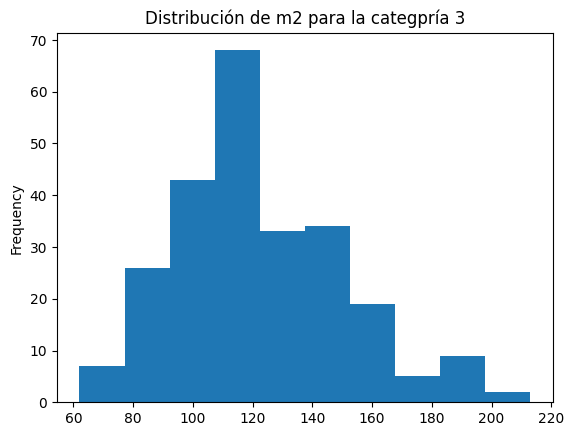

In [26]:
label_cat = 3

full_df[full_df.final_price_bin == label_cat].m2.plot(kind='hist', 
                                                      title=f'Distribución de m2 para la categpría {label_cat}')

In [27]:
full_df[full_df.final_price_bin == label_cat].groupby('num_floors')

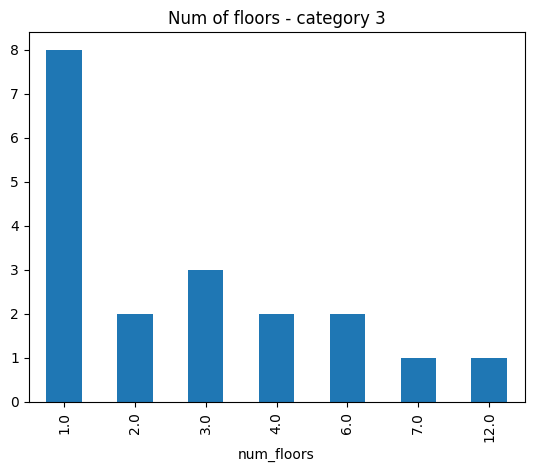

In [28]:
full_df[full_df.final_price_bin == label_cat].groupby('num_floors').count()['main_name'].plot.bar(title=f'Num of floors - category {label_cat}');

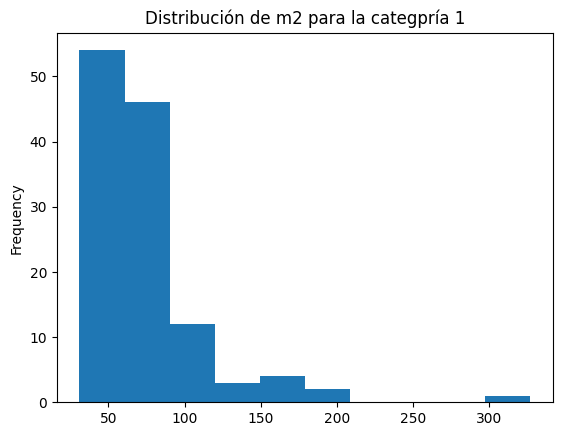

In [29]:
label_cat = 1

full_df[full_df.final_price_bin == label_cat].m2.plot(kind='hist', 
                                                      title=f'Distribución de m2 para la categpría {label_cat}');

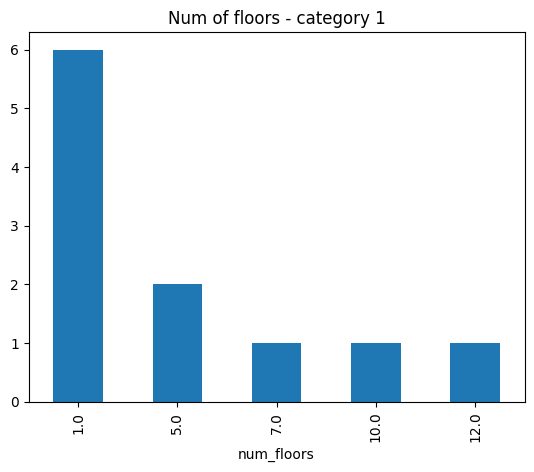

In [30]:
full_df[full_df.final_price_bin == label_cat].groupby('num_floors').count()['main_name'].plot.bar(title=f'Num of floors - category {label_cat}');

En los histogramas anteriores se observa, que existe mucha variabilidad de unas de las características de las propiedades que es el m2.

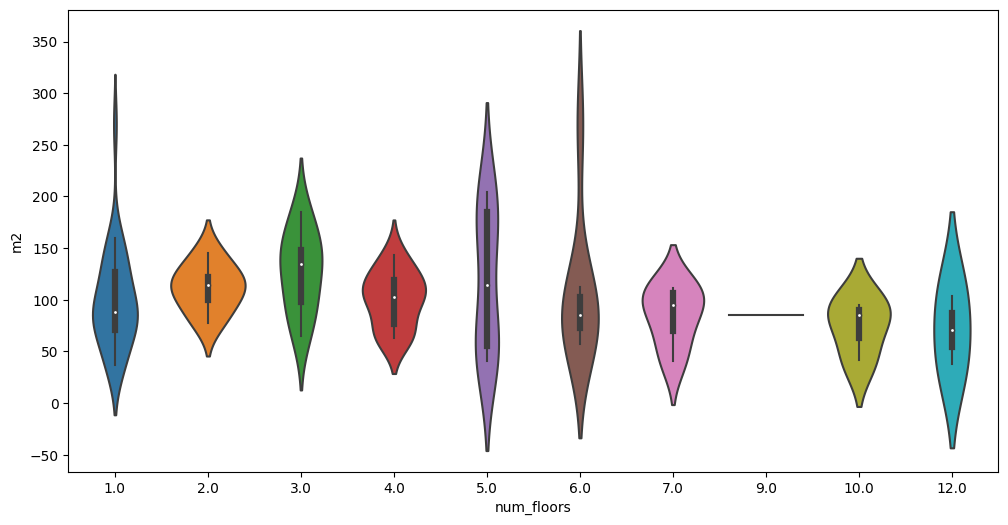

In [31]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='num_floors', 
               y='m2', 
               data=full_df,
               title='Distribución de m2 por número de pisos');

## Entrenamiento del Modelo

Para el entrenamiento del modelo, se seleccionaron pocas variables y se estimará el efecto de cada una.

In [32]:
cols = [
    'days_on_site',
    'bathrooms',
    'since_value',
    'parking_lots',
    'num_bedrooms',
    'm2',
    'neighbourhood',
    'postcode',
    'district',
    'final_price_bin'
]

In [33]:
train_df = full_df[cols]

In [34]:
train_df.isna().sum(axis=0)

days_on_site        0
bathrooms           0
since_value         0
parking_lots        0
num_bedrooms        0
m2                  0
neighbourhood       5
postcode            3
district           41
final_price_bin     0
dtype: int64

In [35]:
train_df.dropna(inplace=True)

Se convertirán las variables categóricas a numéricas. No se utiliza OneHotEncoding debido que existen ciertas categorías con pocos valores y puede crear sparsity.

In [36]:
train_df['neighbourhood_cat'] = train_df['neighbourhood'].astype('category')
train_df['district_cat'] = train_df['district'].astype('category')
train_df['final_price_bin_cat'] = train_df['final_price_bin'].astype('category')

In [37]:
train_df['neighbourhood_cat'] = train_df.neighbourhood_cat.cat.codes
train_df['district_cat'] = train_df.district_cat.cat.codes
train_df['final_price_bin_cat'] = train_df.final_price_bin_cat.cat.codes

In [38]:
train_df_clean = train_df._get_numeric_data()

Se divide los datos de entrenamiento para validar los datos finales.

In [39]:
X = train_df_clean.drop('final_price_bin_cat', axis=1)
y = train_df_clean['final_price_bin_cat']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
rf = RandomForestClassifier(max_depth=10, min_samples_split=50)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=50)

In [42]:
y_pred = rf.predict(x_test)

In [43]:
f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

0.598624264496379

A continuacións se resume las variables maás importantes por el método del árbol.

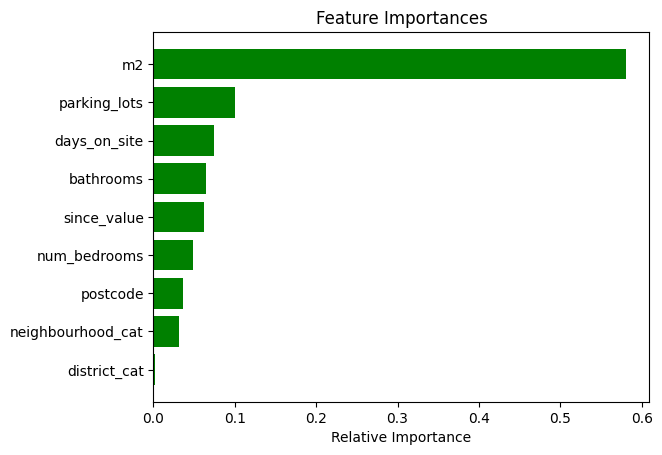

In [44]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = x_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Ahora veamos la importancia de las variables considerando la librería Eli5. Los resultados son muy parecidos a la anterior.

In [45]:
eli5.show_weights(rf, feature_names = list(x_train.columns))

Weight,Feature
0.5806 ± 0.3117,m2
0.1001 ± 0.1945,parking_lots
0.0741 ± 0.0874,days_on_site
0.0646 ± 0.1165,bathrooms
0.0622 ± 0.0918,since_value
0.0485 ± 0.0911,num_bedrooms
0.0368 ± 0.0701,postcode
0.0318 ± 0.0622,neighbourhood_cat
0.0014 ± 0.0083,district_cat


Una forma muy efectiva de evaluar el desempeño de los modelos es con feature importance. Su concepto es muy simple. Se ahce un shuffle de un cierto feature de forma aleatoria. Si el desempeño del model baja considerablemente, se considera que la variable es importante, mientras que si no varía mucho, ese feature no impacta en el modelo.

In [46]:
perm = PermutationImportance(
    rf, 
    scoring = 'accuracy',
    random_state=101).fit(x_test, y_test)

eli5.show_weights(perm, feature_names = list(x_test.columns))

Weight,Feature
0.3074 ± 0.0296,m2
0.0266 ± 0.0135,parking_lots
0.0234 ± 0.0052,bathrooms
0.0223 ± 0.0304,num_bedrooms
0.0085 ± 0.0052,since_value
0.0064 ± 0.0124,neighbourhood_cat
0.0043 ± 0.0156,days_on_site
0.0043 ± 0.0170,postcode
0 ± 0.0000,district_cat


De igual forma se puede ver los pesos de los features de manera local con un instance en específico.

In [47]:
eli5.show_prediction(rf, x_test.iloc[8])